In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Load_Data
import os
import time
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import keras.callbacks
from keras import applications
from keras.applications.vgg16 import VGG16
%matplotlib inline

C:\Users\windo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [2]:
train_data = Load_Data.load_train_data()          #returns a dictionary with xtrain and ytrain as keys
test_data = Load_Data.load_test_data()            #returns a dictionary with xtest and ytest as keys
labels = Load_Data.get_labels()

In [3]:
print(train_data.keys())
print(test_data.keys())

dict_keys(['xtrain', 'ytrain'])
dict_keys(['xtest', 'ytest'])


In [3]:
print(labels)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# Load Resized Data

In [4]:
train_data_reshaped = Load_Data.load_train_data(resize=True, resize_to=(48, 48))          #returns a dictionary with xtrain and ytrain as keys
test_data_reshaped = Load_Data.load_test_data(resize=True, resize_to=(48, 48))            #returns a dictionary with xtest and ytest as keys

Checkin if resized data exists
Data found

Checkin if resized data exists
Data found



# Helper function to plot images

In [5]:
def plot_images(images, true_classes, pred_classes=None, incorrect_pred=False):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.subplots_adjust(hspace = 0.3)
    
    idx = np.random.choice(np.arange(len(images)), 16, replace=False)
    random_images = images[idx]
    random_true_classes = true_classes[idx]
    
    if incorrect_pred:
        random_pred_classes = pred_classes[idx]
        
    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], interpolation='spline16')
        ax.set_xticks([])
        ax.set_yticks([])
        
        msg = 'True : {}'.format(labels[random_true_classes[i]].decode('utf-8'))
        
        if incorrect_pred:
            msg = msg + '\nPred : {}'.format(labels[random_pred_classes[i]].decode('utf-8'))
        ax.set_xlabel(msg)

# Visualization of Data

No of Train Images: 50000
No of Test Images: 10000
Shape of an image: 32 32 3
No of classes: 10
-----------------------------------------------------------
Example Images: 


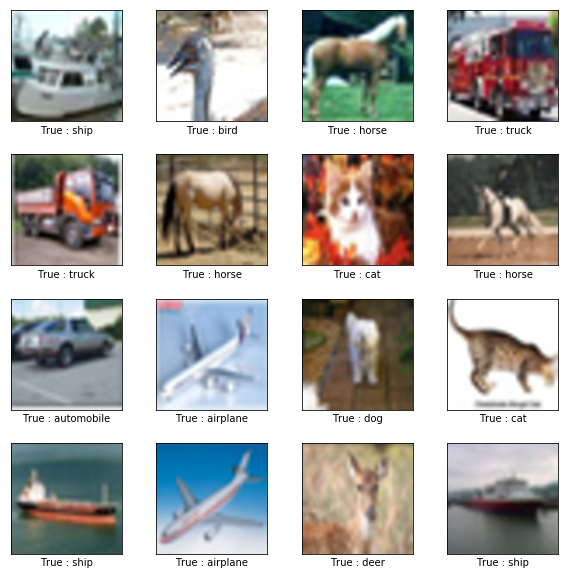

In [20]:
length, breadth, depth = train_data['xtrain'].shape[1:]
no_of_train_images = train_data['xtrain'].shape[0]
no_of_test_images = test_data['xtest'].shape[0]
no_of_classes = len(labels)
print("No of Train Images: {}".format(no_of_train_images))
print("No of Test Images: {}".format(no_of_test_images))
print("Shape of an image: {} {} {}".format(length, breadth, depth))
print("No of classes: {}".format(no_of_classes))
print("-----------------------------------------------------------")
print("Example Images: ")
plot_images(train_data['xtrain'], train_data['ytrain'], labels)

No of Train Images: 50000
No of Test Images: 10000
Shape of an image: 48 48 3
No of classes: 10
-----------------------------------------------------------
Example Images: 


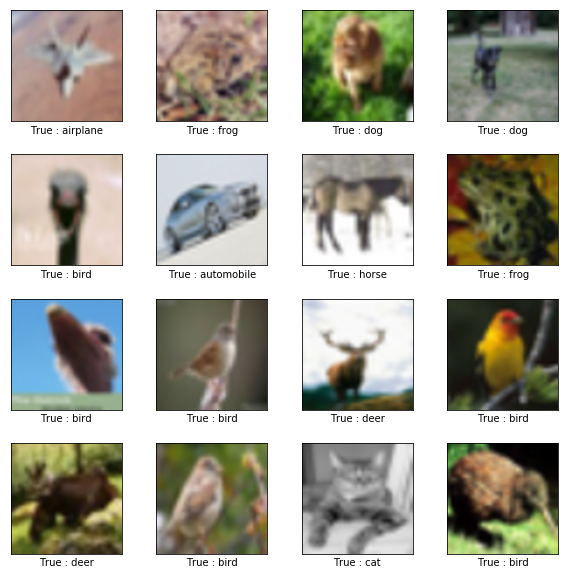

In [6]:
length_reshaped, breadth_reshaped, depth = train_data_reshaped['xtrain'].shape[1:]
no_of_train_images = train_data_reshaped['xtrain'].shape[0]
no_of_test_images = test_data_reshaped['xtest'].shape[0]
no_of_classes = len(labels)
print("No of Train Images: {}".format(no_of_train_images))
print("No of Test Images: {}".format(no_of_test_images))
print("Shape of an image: {} {} {}".format(length_reshaped, breadth_reshaped, depth))
print("No of classes: {}".format(no_of_classes))
print("-----------------------------------------------------------")
print("Example Images: ")
plot_images(train_data_reshaped['xtrain'], train_data_reshaped['ytrain'], labels)

In [7]:
save_dir = 'saved_model/'
save_path = os.path.join(save_dir, 'cifar10_cnn_')

# Helper function to Create Network

In [8]:
def create_pre_trained_network():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(length_reshaped, breadth_reshaped, depth))
    
    add_model = Flatten()(base_model.output)
    add_model = Dense(512, activation='relu')(add_model)
    add_model = Dense(256, activation='relu')(add_model)

    out = Dense(no_of_classes, activation='sigmoid')(add_model)

    model = Model(inputs=base_model.input, outputs=out)
    return model

def create_new_network():
    model = Sequential()

    conv1 = model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape = (length, breadth, depth),\
                             activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    conv2 = model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    conv3 = model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    conv4 = model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    max4 = model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    dense1 = model.add(Dense(units=512, activation='relu'))
    dense2 = model.add(Dense(units=256, activation='relu'))
    dense3 = model.add(Dense(units=128, activation='relu'))
    dense4 = model.add(Dense(units=no_of_classes, activation='softmax'))
    
    return model

def create_network(pre_trained, show_summary):
    print("Creating CNN Network")
    start = time.time()
    
    if pre_trained:
        model = create_pre_trained_network()
    else:
        model = create_new_network()
    
    print("Model Created in {} sec\n".format(time.time()-start))
    if show_summary:
        print("Model Summary")
        model.summary()
    return model

# Helper function to get one-hot-encoded-labels

In [9]:
def get_categorical(ytrain, ytest):
    return (keras.utils.to_categorical(ytrain, num_classes=no_of_classes),\
            keras.utils.to_categorical(ytest, num_classes=no_of_classes))

# Helper function to Train Network

In [20]:
def train_network(train_data, test_data, epochs, verbose, show_summary, pre_trained, initial_epoch=0, model=None):
    
    if initial_epoch == 0:
        model = create_network(pre_trained, show_summary=show_summary)
        print("\n--------------------------------------------")
        print("\nTraining the Network")
        start=time.time()
        opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
    else:
        print("\nTraining the Network for more epochs")
        start=time.time()
        model=model
    
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.005, patience=25,\
                                                                verbose=1, mode='auto')
    ytrain, ytest = get_categorical(train_data['ytrain'], test_data['ytest'])
    model.fit(train_data['xtrain'], ytrain, epochs=epochs, initial_epoch=initial_epoch, verbose=verbose,\
              batch_size=128, callbacks=[early_stopping_callback], validation_data=(test_data['xtest'], ytest), shuffle=True)
    
    print("Model trained in {} sec\n".format(time.time()-start))
    return model

# Helper function to check if model already exists

In [11]:
def is_model_saved(pre_trained):
    print("Trying to restore saved model")
    if pre_trained:
        return os.path.exists(save_path+'using_pre_trained_weights.h5')
    return os.path.exists(save_path+str(len(os.listdir(save_dir)))+'.h5')

In [12]:
def cnn_model(train_data, test_data, epochs, pre_trained=False, initial_epoch=0, verbose=1, show_summary=True, show_accuracy=False):
    model_saved=is_model_saved(pre_trained)
    if initial_epoch != 0 and model_saved:
        print("Previous Model Restored")
        if pre_trained:
            model = load_model(save_path+'using_pre_trained_weights.h5')
        else:
            model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
        print("Loss and Accuracy till now")
        loss_and_accuracy(model, test_data)
        print("--------------------------------------------\n")
        model = train_network(train_data, test_data, epochs, verbose, show_summary, pre_trained, initial_epoch, model)   
    
    elif model_saved:
        print("Model Restored\n\n")
        if pre_trained:
            model = load_model(save_path+'using_pre_trained_weights.h5')
        else:
            model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
            
        if show_summary:
            print("Model Summary")
            model.summary()
            
    else:
        print("Unable to restore model\n\n")
        print("--------------------------------------------\n")
        print("Creating and training new CNN Model\n")
        model = train_network(train_data, test_data, epochs, verbose, show_summary, pre_trained, initial_epoch)
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    print("\n\n--------------------------------------------\n")
    print("Saving trained Model")
    if pre_trained:
        model.save(save_path+'using_pre_trained_weights.h5')
    else:
        model.save(save_path+str(len(os.listdir(save_dir))+1)+'.h5') 
    print("Model Saved")
    
    if show_accuracy:
        print("\n\n--------------------------------------------\n")
        loss_and_accuracy(model, test_data)
    
    return model

# Helper function to train model for more epochs

In [13]:
def train_for_more_epochs(train_data, test_data, epochs, pre_trained, initial_epoch):
    return cnn_model(train_data, test_data, epochs+initial_epoch, pre_trained, initial_epoch)

# Helper function to calculate loss and accuracy

In [14]:
def loss_and_accuracy(model, test_data):
    loss, acc = model.evaluate(test_data['xtest'], keras.utils.to_categorical(test_data['ytest'],10), batch_size=128)
    print("\n\nLoss     : {}\nAccuracy : {}\n".format(loss,acc))

# Helper function to predict classes

In [25]:
def predict_classes(model, xtest):
    pred_classes = model.predict(xtest, verbose=0)
    return pred_classes

# Helper function to plot incorrect predictions

In [39]:
def plot_incorrect_pred(correct, pred_classes, test_data):
    incorrect = (correct == False)
    
    images_incorrect = test_data['xtest'][incorrect]
    true_classes_incorrect = test_data['ytest'][incorrect]
    pred_classes_incorrect = pred_classes[incorrect]
    print("--------------------------------------------")
    print("Incorrect Prediction Examples")
    plot_images(images_incorrect, true_classes_incorrect, pred_classes_incorrect, incorrect_pred=True)

# Helper function to plot confusion matrix

In [40]:
def plot_confusion_matrix(pred_classes, test_data):
    print("--------------------------------------------\n")
    print("Confusion Matrix")
    conf_matrix = confusion_matrix(y_true=test_data['ytest'], y_pred=pred_classes)
    for i in range(len(labels)):
        class_name  = "({}) : {}".format(i, labels[i].decode('utf-8'))
        print(conf_matrix[i], class_name)
    
    class_numbers = [" ({0})".format(i) for i in range(len(labels))]
    print("".join(class_numbers))

# Helper function to calculate accuracy on test images

In [42]:
def classification_accuracy(correct):
    mean = correct.mean()
    total_correct = correct.sum()
    return mean,total_correct

def test_accuracy(model, test_data, pre_trained=False, show_confusion_matrix = False, show_example_errors = False):
    pred_classes = predict_classes(model, test_data['xtest'])
    
    if pre_trained:
        pred_classes = np.argmax(pred_classes, axis=1)
    
    correct = (pred_classes == test_data['ytest'])   
    accuracy, total_correct = classification_accuracy(correct)
    
    print("\nClassification Accuracy on Test Set : {0:.1%}".format(accuracy))
    print("Total Images : {}".format(len(pred_classes)))
    print("Correct Predictions : {}".format(total_correct))
    print("Incorrect Predictions : {}\n".format(len(pred_classes)-total_correct))
    
    if show_confusion_matrix:
        plot_confusion_matrix(pred_classes, test_data)
    
    if show_example_errors:
        plot_incorrect_pred(correct, pred_classes, test_data)

In [25]:
# model = load_model(save_path+str(len(os.listdir(save_dir)))+'.h5')
epochs = 50
model=cnn_model(train_data, test_data, epochs=epochs)

Trying to restore saved model
Unable to restore model


--------------------------------------------

Creating and training new CNN Model

Creating CNN Network
Model Created in 0.33794498443603516 sec

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)          0         
__________________________________________________________

In [26]:
loss_and_accuracy(model, test_data)

10000/10000 [==============================] - 1s 83us/step


Loss     : 0.9578592441558837
Accuracy : 0.6602



In [20]:
#run this code to train for more epochs

# more_epochs=50
# initial_epoch=epochs
# model = train_for_more_epochs(train_data, test_data, epochs=more_epochs, pre_trained=False, initial_epoch=initial_epoch)


Classification Accuracy on Test Set : 66.0%
Total Images : 10000
Correct Predictions : 6602
Incorrect Predictions : 3398

--------------------------------------------

Confusion Matrix
[683  21 104  26  28   3  13  12  71  39] (0) : airplane
[ 36 740  10  26   5   2  33   5  29 114] (1) : automobile
[ 56   1 537  96  99  78  95  23   7   8] (2) : bird
[  6   2  97 489  49 206 105  20  15  11] (3) : cat
[ 20   3  91  83 596  32 100  66   7   2] (4) : deer
[  9   1  72 247  39 570  25  33   1   3] (5) : dog
[  2   3  55  77  23   8 827   3   0   2] (6) : frog
[  9   1  35  71  94 121  10 645   0  14] (7) : horse
[116  28  27  37  12   3  13   6 719  39] (8) : ship
[ 26  60  10  37   8   2  13  16  32 796] (9) : truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
--------------------------------------------
Incorrect Prediction Examples


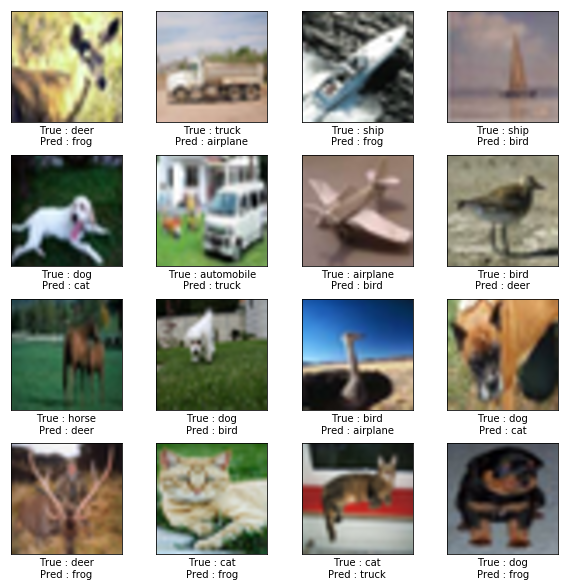

In [27]:
test_accuracy(model, test_data, show_confusion_matrix = True, show_example_errors = True)

In [22]:
epochs = 15
model_pre_trained=cnn_model(train_data_reshaped, test_data_reshaped, epochs=epochs, pre_trained=True)

Trying to restore saved model
Unable to restore model


--------------------------------------------

Creating and training new CNN Model

Creating CNN Network
Model Created in 0.6036043167114258 sec

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
___________________________________________________________

In [23]:
loss_and_accuracy(model_pre_trained, test_data_reshaped)

10000/10000 [==============================] - 5s 461us/step


Loss     : 0.45776696090698243
Accuracy : 0.8959




Classification Accuracy on Test Set : 89.6%
Total Images : 10000
Correct Predictions : 8959
Incorrect Predictions : 1041

--------------------------------------------

Confusion Matrix
[927   6  13   7   6   1   3   5  29   3] (0) : airplane
[ 10 952   1   1   0   0   0   0   8  28] (1) : automobile
[ 30   0 882  16  29   5  26   8   2   2] (2) : bird
[  7   6  33 794  24  70  38  15   8   5] (3) : cat
[  5   1  27  28 897   8  11  19   3   1] (4) : deer
[  5   0  17 129  25 785  15  22   1   1] (5) : dog
[  5   0  12  29   8   3 940   1   1   1] (6) : frog
[  9   1  12  21  20  21   2 910   4   0] (7) : horse
[ 28   7   3   1   0   0   1   0 952   8] (8) : ship
[ 10  47   2   4   1   0   2   1  13 920] (9) : truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)
--------------------------------------------
Incorrect Prediction Examples


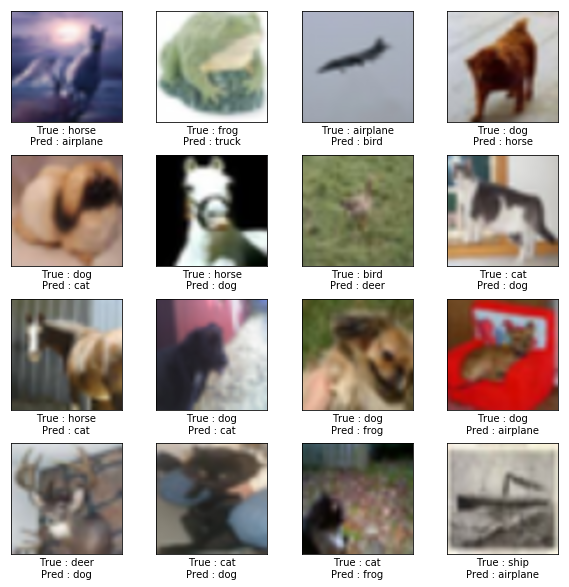

In [43]:
test_accuracy(model_pre_trained, test_data_reshaped, pre_trained=True, show_confusion_matrix = True, show_example_errors = True)

In [45]:
import cv2

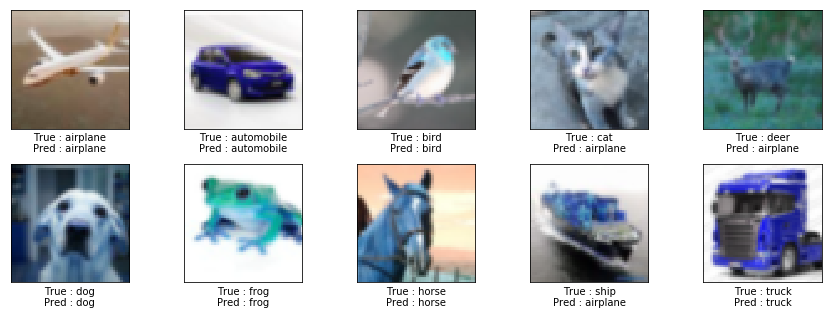

In [53]:
example_images_path = 'example_images'
files = os.listdir(example_images_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flat
fig.subplots_adjust(hspace = 0.3)

for i, ax in enumerate(axes):
    img = cv2.imread(example_images_path + '/' + files[i])
    img = cv2.pyrDown(img)
    img = cv2.resize(img,(48, 48), interpolation = cv2.INTER_LINEAR)
    
#     img = cv2.resize(img, (32, 32))

    #Predicting the class
#     pred = predict_classes(model_pre_trained, img.reshape(1, 48, 48, 3))
    pred = model_pre_trained.predict(img.reshape(1, 48, 48, 3), verbose=0)
    pred = np.argmax(pred)
#     print(pred)
    pred_label = labels[pred].decode('utf-8')
    act_label = os.path.splitext(files[i])[0]
    ax.imshow(img)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    msg = 'True : {}\nPred : {}'.format(act_label, pred_label)
    ax.set_xlabel(msg)